In [1]:
# Core
import os
import math
import numpy as np
import pandas as pd
import sys

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Settings
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)
sns.set_theme(context='notebook', style='whitegrid')
np.random.seed(42)
tf.random.set_seed(42)

# Optimize CPU performance
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'
tf.config.threading.set_inter_op_parallelism_threads(0)  # Auto
tf.config.threading.set_intra_op_parallelism_threads(0)  # Auto

# Paths
DATA_PATH = 'lending_club_loan_two.csv'

# Check GPU/CPU
gpus = tf.config.list_physical_devices('GPU')
print(f'TensorFlow: {tf.__version__}')
print(f'Device: {"GPU" if gpus else "CPU"} ({len(gpus)} GPUs)' if gpus else f'Device: CPU (optimized)')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
        print(f'  {gpu.name}')



TensorFlow: 2.20.0
Device: CPU (optimized)


In [2]:
# Load data
assert os.path.exists(DATA_PATH), f"Missing data file at {DATA_PATH}"
df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head(3)


(396030, 27)


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113"


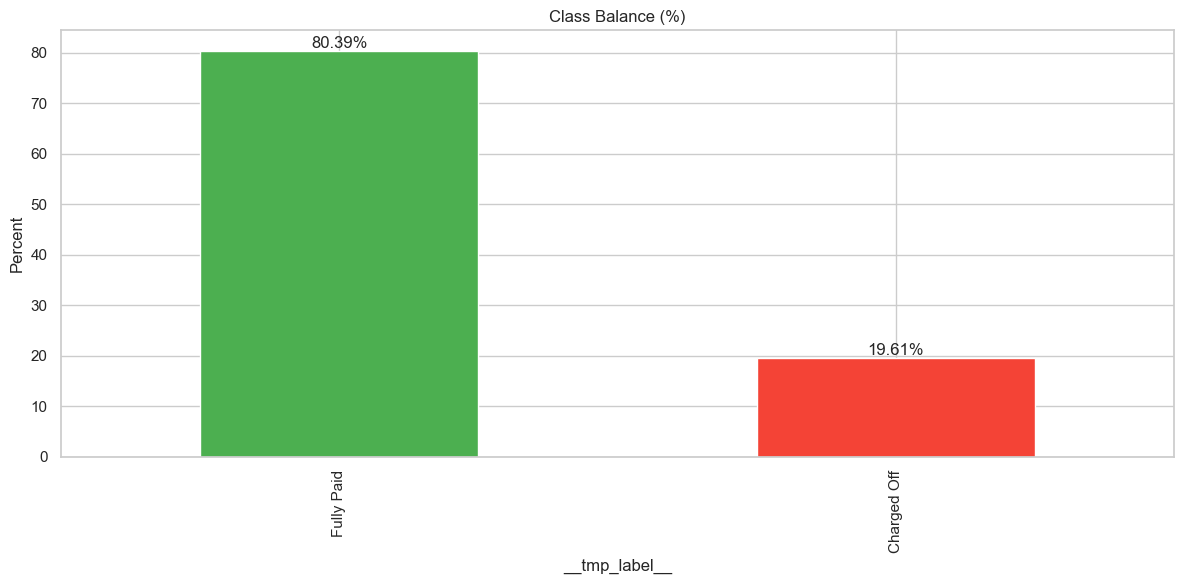

Conclusion: Charged-off rate is 19.61% (imbalanced).


In [3]:
# EDA: class balance (robust to missing `label`)
df_eda = df.copy()
label_col = 'label'
if label_col not in df_eda.columns:
    if 'loan_status' in df_eda.columns:
        mask = df_eda['loan_status'].isin(['Fully Paid', 'Charged Off'])
        df_eda = df_eda[mask].copy()
        df_eda['__tmp_label__'] = (df_eda['loan_status'] == 'Charged Off').astype(int)
        label_col = '__tmp_label__'
    else:
        print('No `label` or `loan_status` available for class balance plot.')
        label_col = None

if label_col is not None:
    fig, ax = plt.subplots(figsize=(12,6))
    vc = df_eda[label_col].value_counts(normalize=True)
    (vc.rename({0:'Fully Paid',1:'Charged Off'})
       .mul(100).round(2)
       .plot(kind='bar', ax=ax, color=['#4caf50','#f44336']))
    ax.set_title('Class Balance (%)')
    ax.set_ylabel('Percent')
    for i, v in enumerate(vc.mul(100).round(2).values):
        ax.text(i, v + 0.5, f"{v:.2f}%", ha='center')
    plt.tight_layout()
    plt.show()

    pos_rate = df_eda[label_col].mean()
    status = 'imbalanced' if (pos_rate < 0.3 or pos_rate > 0.7) else 'moderately balanced'
    print(f"Conclusion: Charged-off rate is {pos_rate:.2%} ({status}).")


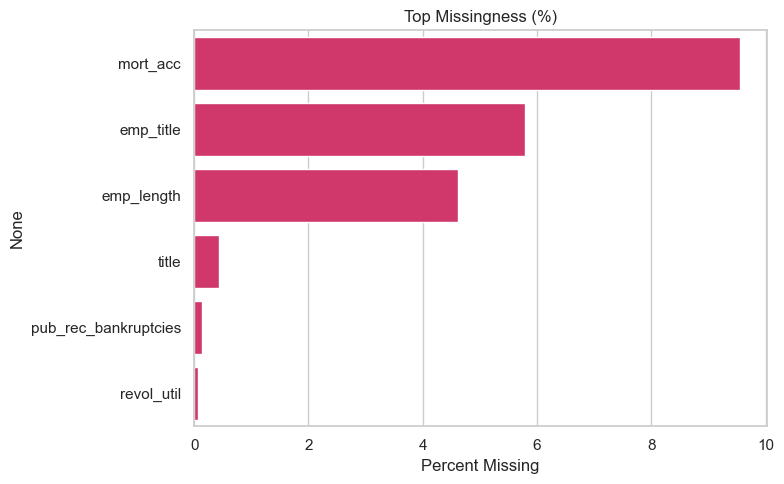

Conclusion: 6 columns have missing values. Top: mort_acc: 9.5%, emp_title: 5.8%, emp_length: 4.6%.


In [4]:
# EDA: missingness heatmap (top columns)
na_frac = df.isna().mean().sort_values(ascending=False)
top_na = na_frac[na_frac > 0].head(20)
if not top_na.empty:
    plt.figure(figsize=(8,5))
    sns.barplot(x=top_na.values*100, y=top_na.index, color='#e91e63')
    plt.title('Top Missingness (%)')
    plt.xlabel('Percent Missing')
    plt.tight_layout()
    plt.show()

    total_na_cols = int((na_frac > 0).sum())
    top3 = top_na.head(3)
    top3_txt = ", ".join([f"{col}: {pct*100:.1f}%" for col, pct in top3.items()])
    print(f"Conclusion: {total_na_cols} columns have missing values. Top: {top3_txt}.")
else:
    print('No missing values detected.')


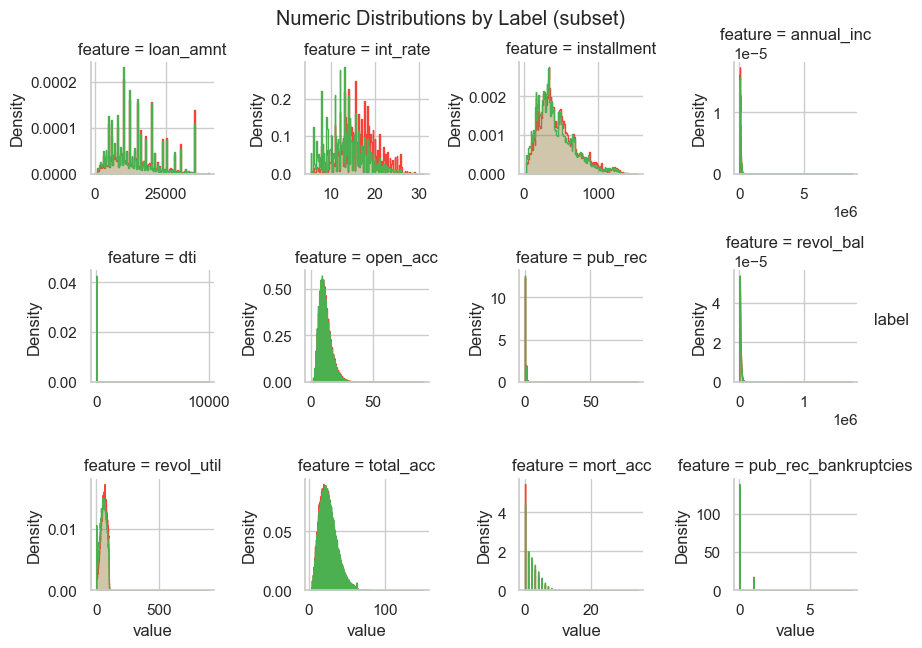

Conclusion: Many numerics are heavily skewed. Skewed subset: ['annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal']...


In [5]:
# EDA: numeric distributions (subset) robust
num_cols = [c for c in df_eda.select_dtypes(include=[np.number]).columns if c != label_col]
show_cols = num_cols[:12]
if show_cols and (label_col is not None) and (label_col in df_eda.columns):
    df_m = df_eda[show_cols + [label_col]].melt(id_vars=label_col, var_name='feature', value_name='value')
    g = sns.FacetGrid(df_m, col='feature', col_wrap=4, sharex=False, sharey=False, height=2.2)
    g.map_dataframe(sns.histplot, x='value', hue=label_col, element='step', stat='density', common_norm=False, palette={0:'#4caf50',1:'#f44336'})
    g.add_legend(title='label')
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle('Numeric Distributions by Label (subset)')
    plt.show()

    skewed = [c for c in show_cols if abs(pd.Series(df_eda[c]).skew(skipna=True)) > 1]
    print(f"Conclusion: Many numerics are {'heavily ' if len(skewed)>0 else ''}skewed. Skewed subset: {skewed[:5]}...")
else:
    print('Not enough numeric columns or missing label for distributions.')


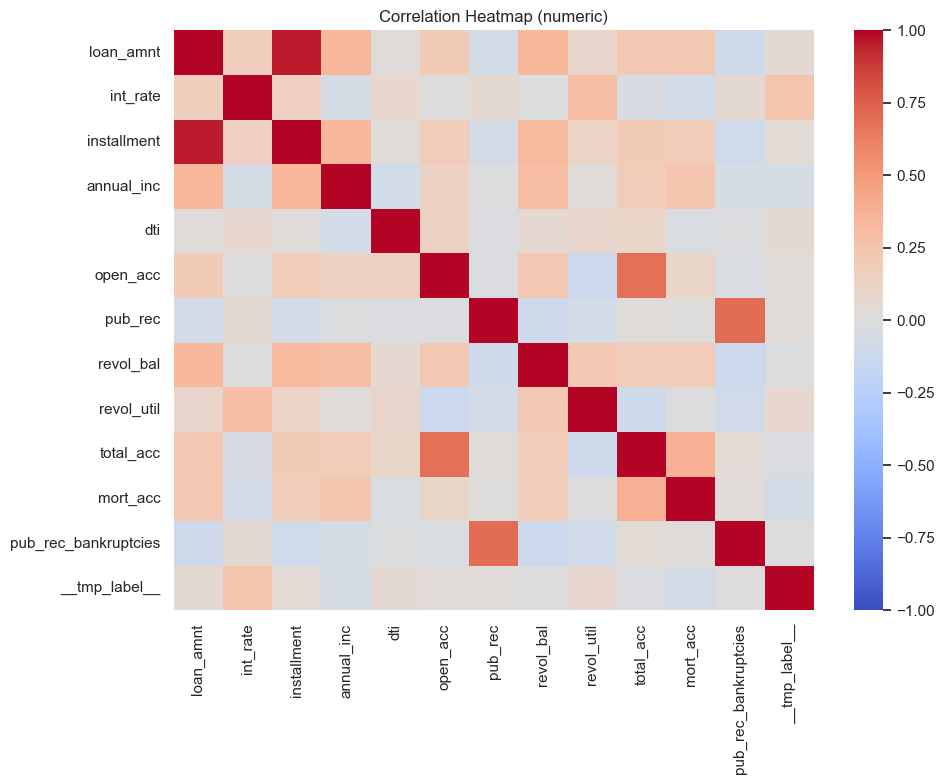

Conclusion: 1 high-correlation numeric pairs (>0.8). Consider dropping/combining.


In [6]:
# EDA: correlation heatmap (numeric)
if len(num_cols) > 1 and (label_col is not None) and (label_col in df_eda.columns):
    corr = df_eda[num_cols + [label_col]].corr(numeric_only=True)
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title('Correlation Heatmap (numeric)')
    plt.tight_layout()
    plt.show()

    high_corr = [(i,j) for i in num_cols for j in num_cols if i<j and abs(corr.loc[i,j])>0.8]
    print(f"Conclusion: {len(high_corr)} high-correlation numeric pairs (>0.8). Consider dropping/combining.")
else:
    print('Not enough numeric columns or missing label for correlation heatmap.')


C:\Users\Artur\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\cluster\_supervised.py:49: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_label = type_of_target(labels_true)
C:\Users\Artur\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\cluster\_supervised.py:49: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_label = type_of_target(labels_true)


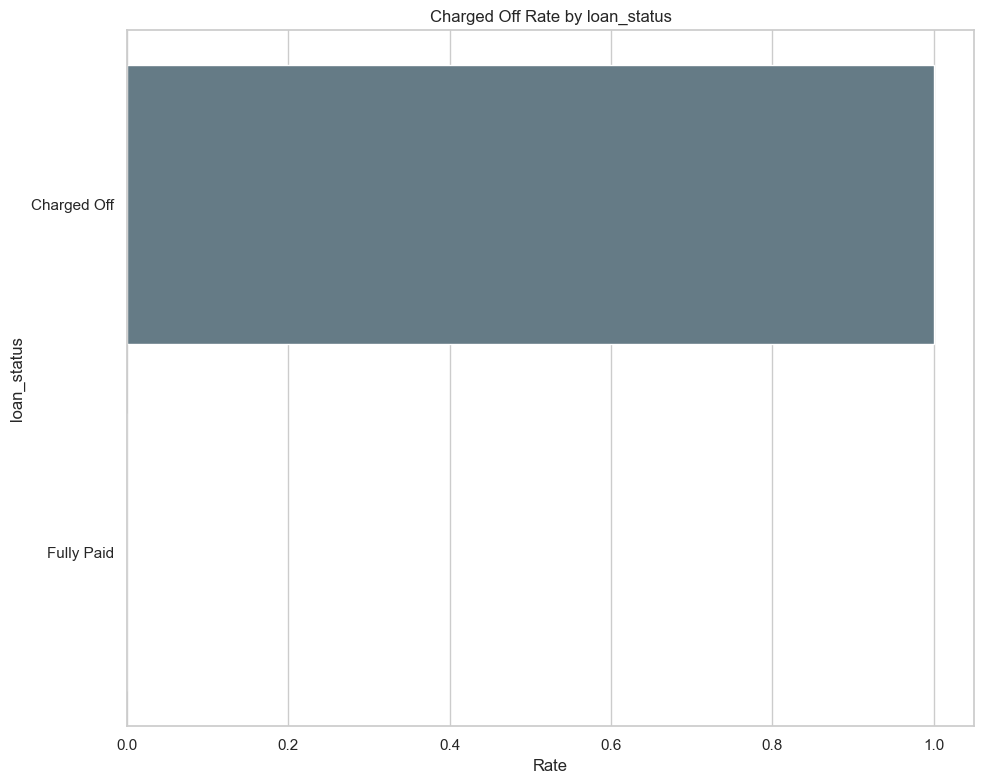

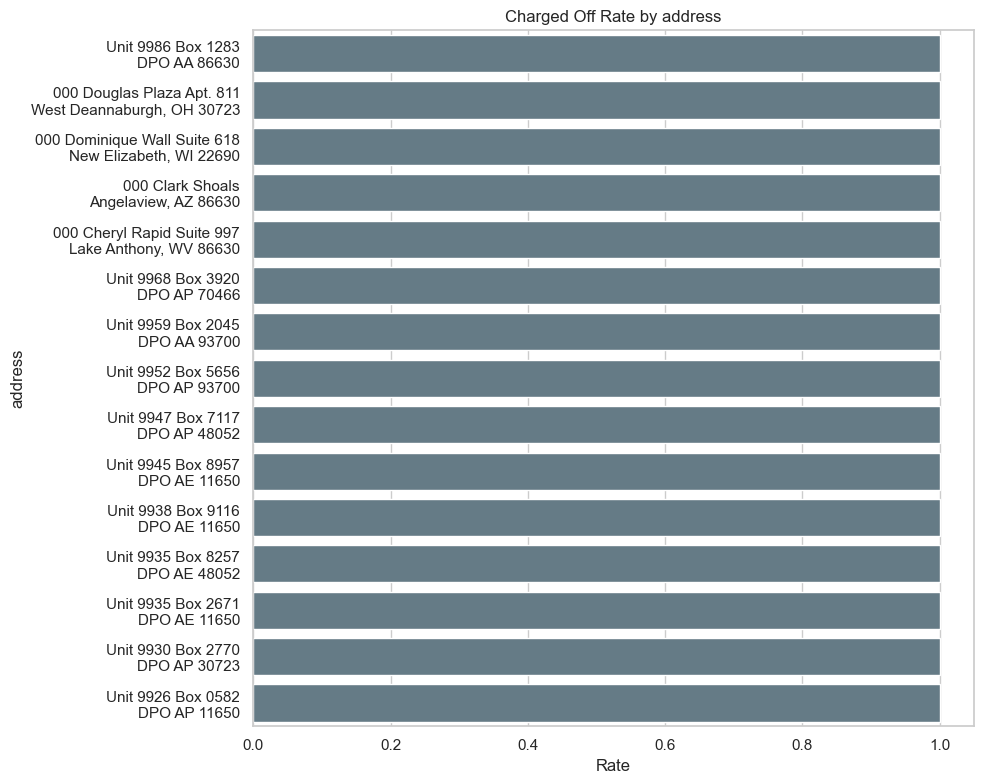

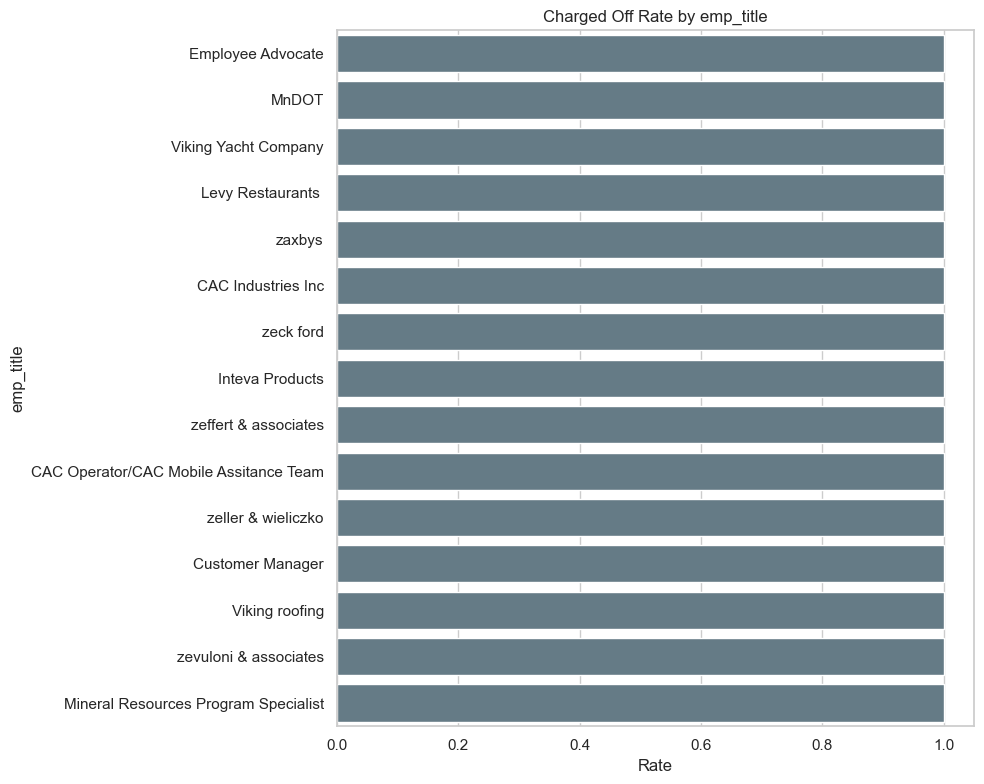

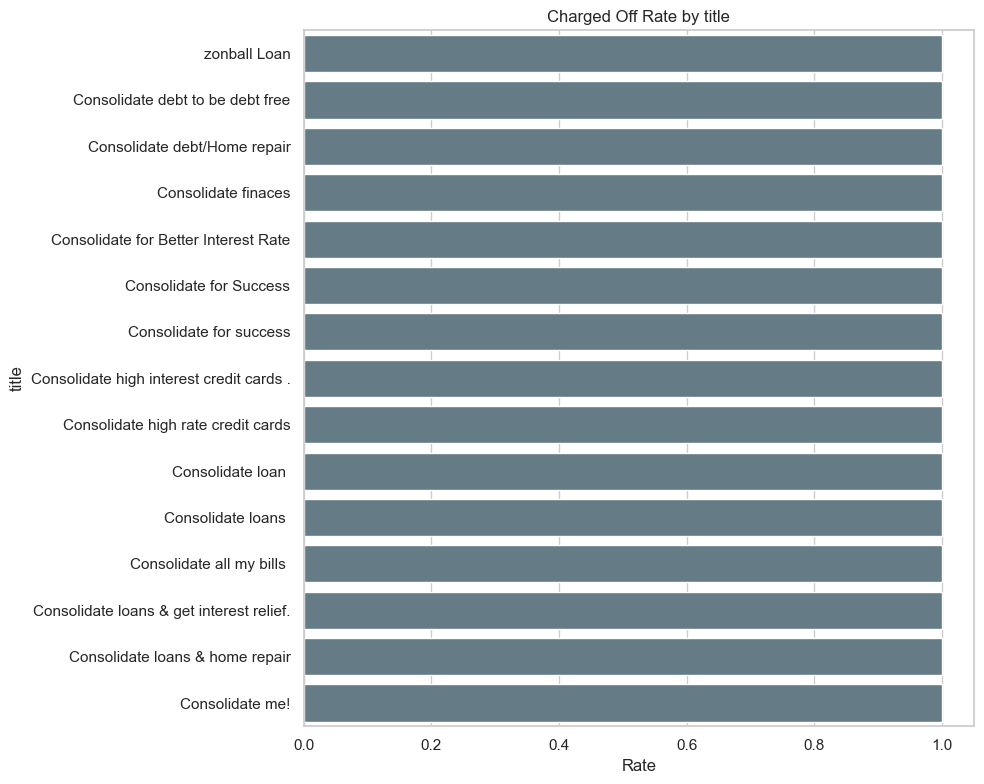

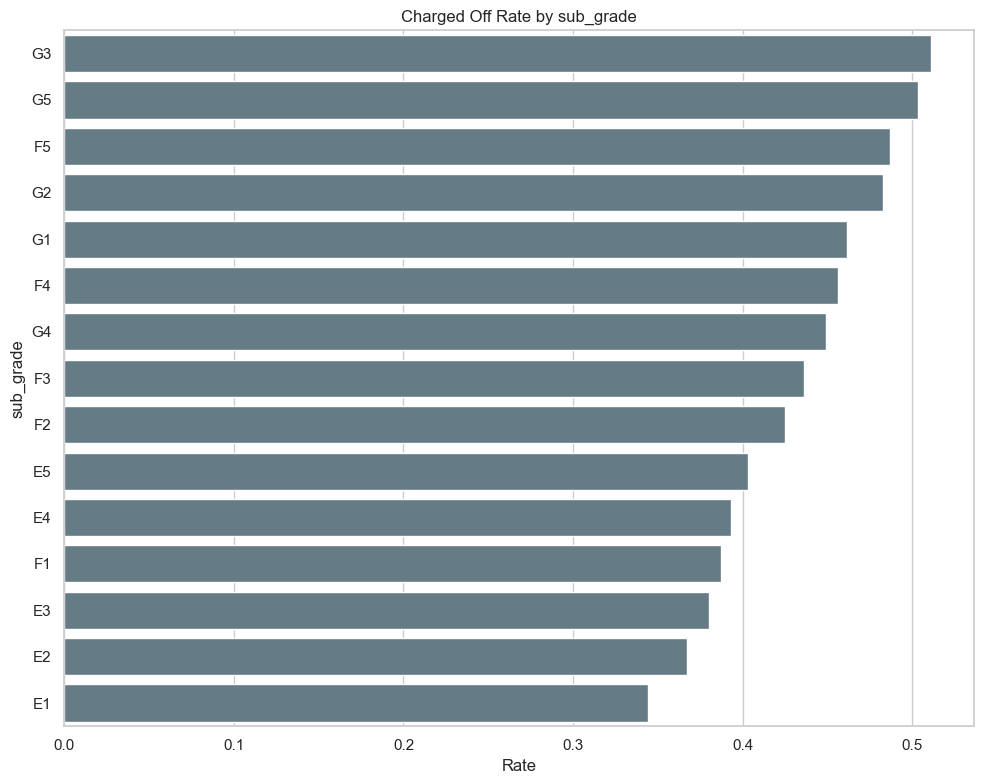

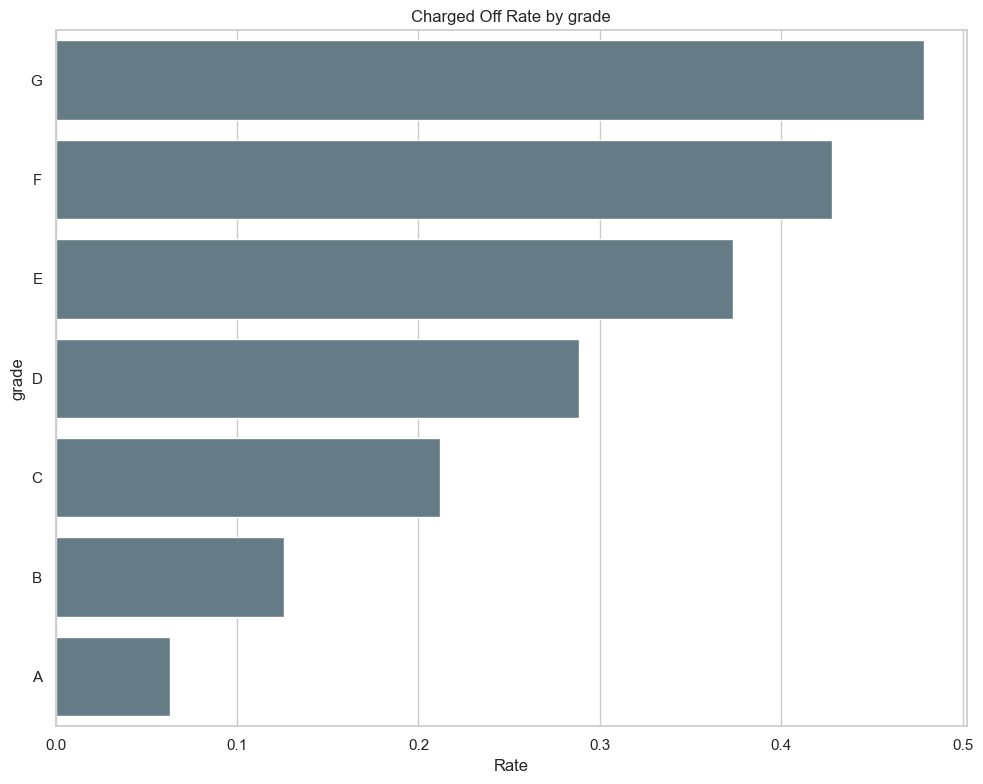

Conclusion: Strong categorical signal in loan_status. Top groups: Charged Off: 100.00%, Fully Paid: 0.00%.


In [7]:
# EDA: categorical default rates (top 6 by mutual info) robust
from sklearn.feature_selection import mutual_info_classif

if label_col is not None:
    cat_cols_all = [c for c in df_eda.select_dtypes(include=['object','category','bool']).columns if c not in [label_col]]
    # compute MI on ordinal-encoded temporary representation
    mi_samples = min(len(df_eda), 20000)
    df_sample = df_eda.sample(mi_samples, random_state=42) if len(df_eda) > mi_samples else df_eda.copy()

    mi_scores = []
    for c in cat_cols_all:
        vals, inv = pd.factorize(df_sample[c], sort=True)
        try:
            score = mutual_info_classif(vals.reshape(-1,1), df_sample[label_col], discrete_features=True, random_state=42)
            mi_scores.append((c, float(score[0])))
        except Exception:
            continue
    mi_scores = sorted(mi_scores, key=lambda x: x[1], reverse=True)[:6]

    for c, _ in mi_scores:
        plt.figure(figsize=(10,8))
        rate = df_eda.groupby(c)[label_col].mean().sort_values(ascending=False).head(15)
        sns.barplot(x=rate.values, y=rate.index, color='#607d8b')
        plt.title(f'Charged Off Rate by {c}')
        plt.xlabel('Rate')
        plt.tight_layout()
        plt.show()

    if mi_scores:
        top_c, _ = mi_scores[0]
        top_rate = df_eda.groupby(top_c)[label_col].mean().sort_values(ascending=False)
        top_head = ", ".join([f"{k}: {v:.2%}" for k, v in top_rate.head(3).items()])
        print(f"Conclusion: Strong categorical signal in {top_c}. Top groups: {top_head}.")
else:
    print('Missing label; skipping categorical default rate plots.')


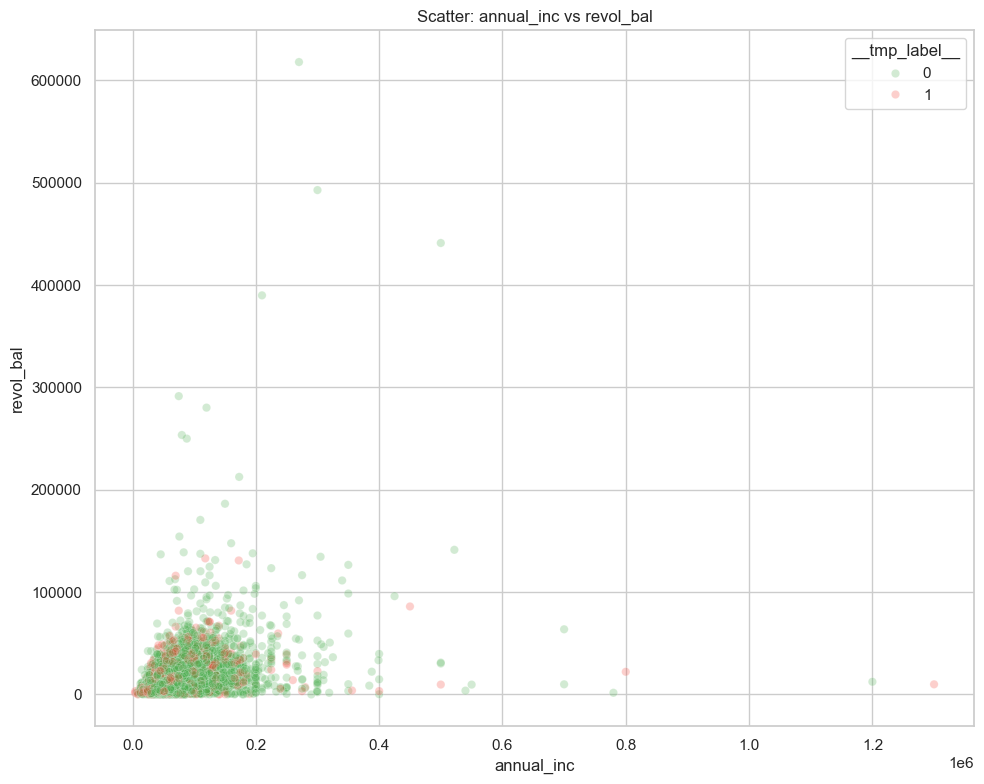

Conclusion: Visible separation suggests annual_inc and revol_bal carry signal.


In [8]:
# EDA: sampled scatter for two top numeric features vs label (robust)
import itertools

if len(num_cols) >= 2 and (label_col is not None) and (label_col in df_eda.columns):
    # pick top-variance numeric features
    var = df_eda[num_cols].var().sort_values(ascending=False)
    top2 = list(var.head(2).index)
    plt.figure(figsize=(10,8))
    sns.scatterplot(data=df_eda.sample(min(len(df_eda), 8000), random_state=42), x=top2[0], y=top2[1], hue=label_col, alpha=0.25, palette={0:'#4caf50',1:'#f44336'})
    plt.title(f'Scatter: {top2[0]} vs {top2[1]}')
    plt.tight_layout()
    plt.show()

    print(f"Conclusion: Visible separation suggests {top2[0]} and {top2[1]} carry signal.")
else:
    print('Not enough numeric features or missing label for scatter.')


In [9]:
# Target mapping and quick clean
# Expect 'loan_status' with values like 'Fully Paid' vs 'Charged Off'
df = df.copy()

# Drop obviously leakage or high-cardinality identifiers if present
leak_cols = [
    'issue_d',           # post-application timing
    'emp_title',         # high-cardinality text
    'title',             # high-cardinality text
    'url', 'desc',       # text
    'zip_code',          # sparse categorical
    'addr_state',        # can keep, but optional
    'earliest_cr_line',  # date-like
    'sub_grade'          # redundant with grade
]
for c in leak_cols:
    if c in df.columns:
        df.drop(columns=c, inplace=True)

# Map target
assert 'loan_status' in df.columns, 'Expected loan_status column'
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])].copy()
df['label'] = (df['loan_status'] == 'Charged Off').astype(int)
df.drop(columns=['loan_status'], inplace=True)

# Handle missing numeric/categorical
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'label' in numeric_cols:
    numeric_cols.remove('label')
cat_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# Simple imputations
for c in numeric_cols:
    if df[c].isna().any():
        df.loc[:, c] = df[c].fillna(df[c].median())
for c in cat_cols:
    if df[c].isna().any():
        df.loc[:, c] = df[c].fillna(df[c].mode().iloc[0])

print('Rows after filter:', len(df))
print('Positive rate:', df['label'].mean().round(4))
df.head(3)


Rows after filter: 396030
Positive rate: 0.1961


,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address,label
0,10000.0,36 months,11.44,329.48,B,10+ years,RENT,117000.0,Not Verified,vacation,26.24,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690",0
1,8000.0,36 months,11.99,265.68,B,4 years,MORTGAGE,65000.0,Not Verified,debt_consolidation,22.05,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113",0
2,15600.0,36 months,10.49,506.97,B,< 1 year,RENT,43057.0,Source Verified,credit_card,12.79,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113",0


In [10]:
# Encode categoricals and scale numericals
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != 'label']
all_cat_cols = [c for c in df.columns if c not in numeric_cols + ['label']]

# Keep only low-cardinality categoricals + a small whitelist common in LendingClub
low_card_limit = 30
low_card_cats = [c for c in all_cat_cols if df[c].nunique(dropna=False) <= low_card_limit]
whitelist = ['term', 'grade', 'home_ownership', 'verification_status', 'purpose', 'application_type', 'initial_list_status']
cat_cols = sorted(set(low_card_cats) | {c for c in whitelist if c in df.columns})
print('Kept categoricals (name: #levels):', {c: int(df[c].nunique(dropna=False)) for c in cat_cols})

# OneHotEncoder with infrequent bucketing if available; dense output
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=0.01)
except TypeError:
    try:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(with_mean=True), numeric_cols),
        ('cat', ohe, cat_cols),
    ],
    remainder='drop'
)

X = df.drop(columns=['label'])
y = df['label'].values

# Fit transform to get a dense feature matrix (cast to float32 to reduce RAM)
X_proc = preprocess.fit_transform(X)
if hasattr(X_proc, 'astype'):
    X_proc = X_proc.astype(np.float32, copy=False)
feature_names = list(numeric_cols) + list(preprocess.named_transformers_['cat'].get_feature_names_out(cat_cols))
print('X_proc shape:', X_proc.shape)



Kept categoricals (name: #levels): {'application_type': 3, 'emp_length': 11, 'grade': 7, 'home_ownership': 6, 'initial_list_status': 2, 'purpose': 14, 'term': 2, 'verification_status': 3}
X_proc shape: (396030, 52)


In [11]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_proc, y, test_size=0.2, random_state=42, stratify=y
)

pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()
print('Train size:', X_train.shape, 'Test size:', X_test.shape)
print('Class balance train:', y_train.mean().round(4), 'pos_weight:', round(float(pos_weight), 2))


Train size: (316824, 52) Test size: (79206, 52)
Class balance train: 0.1961 pos_weight: 4.1


In [12]:
# Build and train Keras model (CPU-optimized)
input_dim = X_train.shape[1]

def make_model():
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid'),
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=[keras.metrics.AUC(name='auc'), 'accuracy'],
        jit_compile=False  # XLA disabled for CPU
    )
    return model

model = make_model()
callbacks = [
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_auc', mode='max')
]
class_weight = {0: 1.0, 1: float(pos_weight)}

# Larger batch size for CPU efficiency
batch_size = 2048 if not tf.config.list_physical_devices('GPU') else 1024

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=batch_size,
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=1,
)

pd.DataFrame(history.history)[['loss','val_loss','auc','val_auc']].tail()


Epoch 1/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6337 - auc: 0.6941 - loss: 1.0195 - val_accuracy: 0.6593 - val_auc: 0.7093 - val_loss: 0.6088
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6419 - auc: 0.7069 - loss: 1.0049 - val_accuracy: 0.6584 - val_auc: 0.7115 - val_loss: 0.6110
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6430 - auc: 0.7098 - loss: 1.0014 - val_accuracy: 0.6576 - val_auc: 0.7129 - val_loss: 0.6079
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6445 - auc: 0.7118 - loss: 0.9986 - val_accuracy: 0.6607 - val_auc: 0.7138 - val_loss: 0.6064
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6458 - auc: 0.7135 - loss: 0.9964 - val_accuracy: 0.6596 - val_auc: 0.7145 - val_loss: 0.6070
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6474 - auc: 0.7147 - loss: 0.9953 - val_accuracy: 0.6638 - val_auc: 0.7149 - val_loss: 0.6039
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━

,loss,val_loss,auc,val_auc
15,0.985702,0.606985,0.721950,0.716630
16,0.985215,0.606440,0.722854,0.716811
17,0.984597,0.603684,0.723160,0.716450
18,0.983861,0.607616,0.723630,0.716311
19,0.983281,0.606724,0.724061,0.716272


2476/2476 ━━━━━━━━━━━━━━━━━━━━ 2s 662us/step
ROC AUC: 0.7172

Classification Report
               precision    recall  f1-score   support

           0     0.8876    0.6613    0.7579     63671
           1     0.3211    0.6566    0.4313     15535

    accuracy                         0.6604     79206
   macro avg     0.6044    0.6590    0.5946     79206
weighted avg     0.7765    0.6604    0.6939     79206



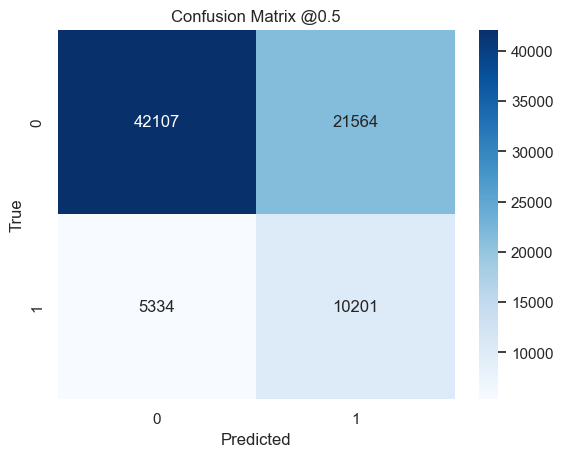

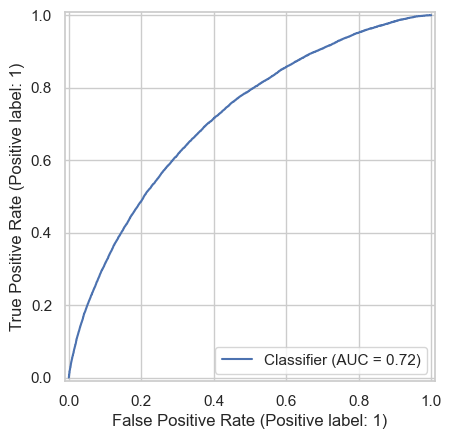

Saved model and feature names to keras_lc_model.keras and feature_names.csv


In [13]:
# Evaluate
probs = model.predict(X_test).ravel()
preds = (probs >= 0.5).astype(int)

print(f"ROC AUC: {roc_auc_score(y_test, probs):.4f}")
print('\nClassification Report\n', classification_report(y_test, preds, digits=4))

cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix @0.5')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

RocCurveDisplay.from_predictions(y_test, probs)
plt.show()

# Save artifacts
model.save('keras_lc_model.keras')
pd.Series(feature_names).to_csv('feature_names.csv', index=False)
print('Saved model and feature names to keras_lc_model.keras and feature_names.csv')
